# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd              # подключаем библиотеку pandas
import matplotlib.pyplot as plt  # подскючаем библиотеку для работы с графикой

In [2]:
pd.set_option('display.max_columns', None) # отобразим все столбцы датафрейма
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/Users/sergeipakhar/Desktop/Phyton/3 СПРИНТ Исследовательский анализ данных/real_estate_data.csv', sep='\t')
data.info() # смотрим данные о датафрейме
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.duplicated().sum() # проверка на явные дубликаты

0

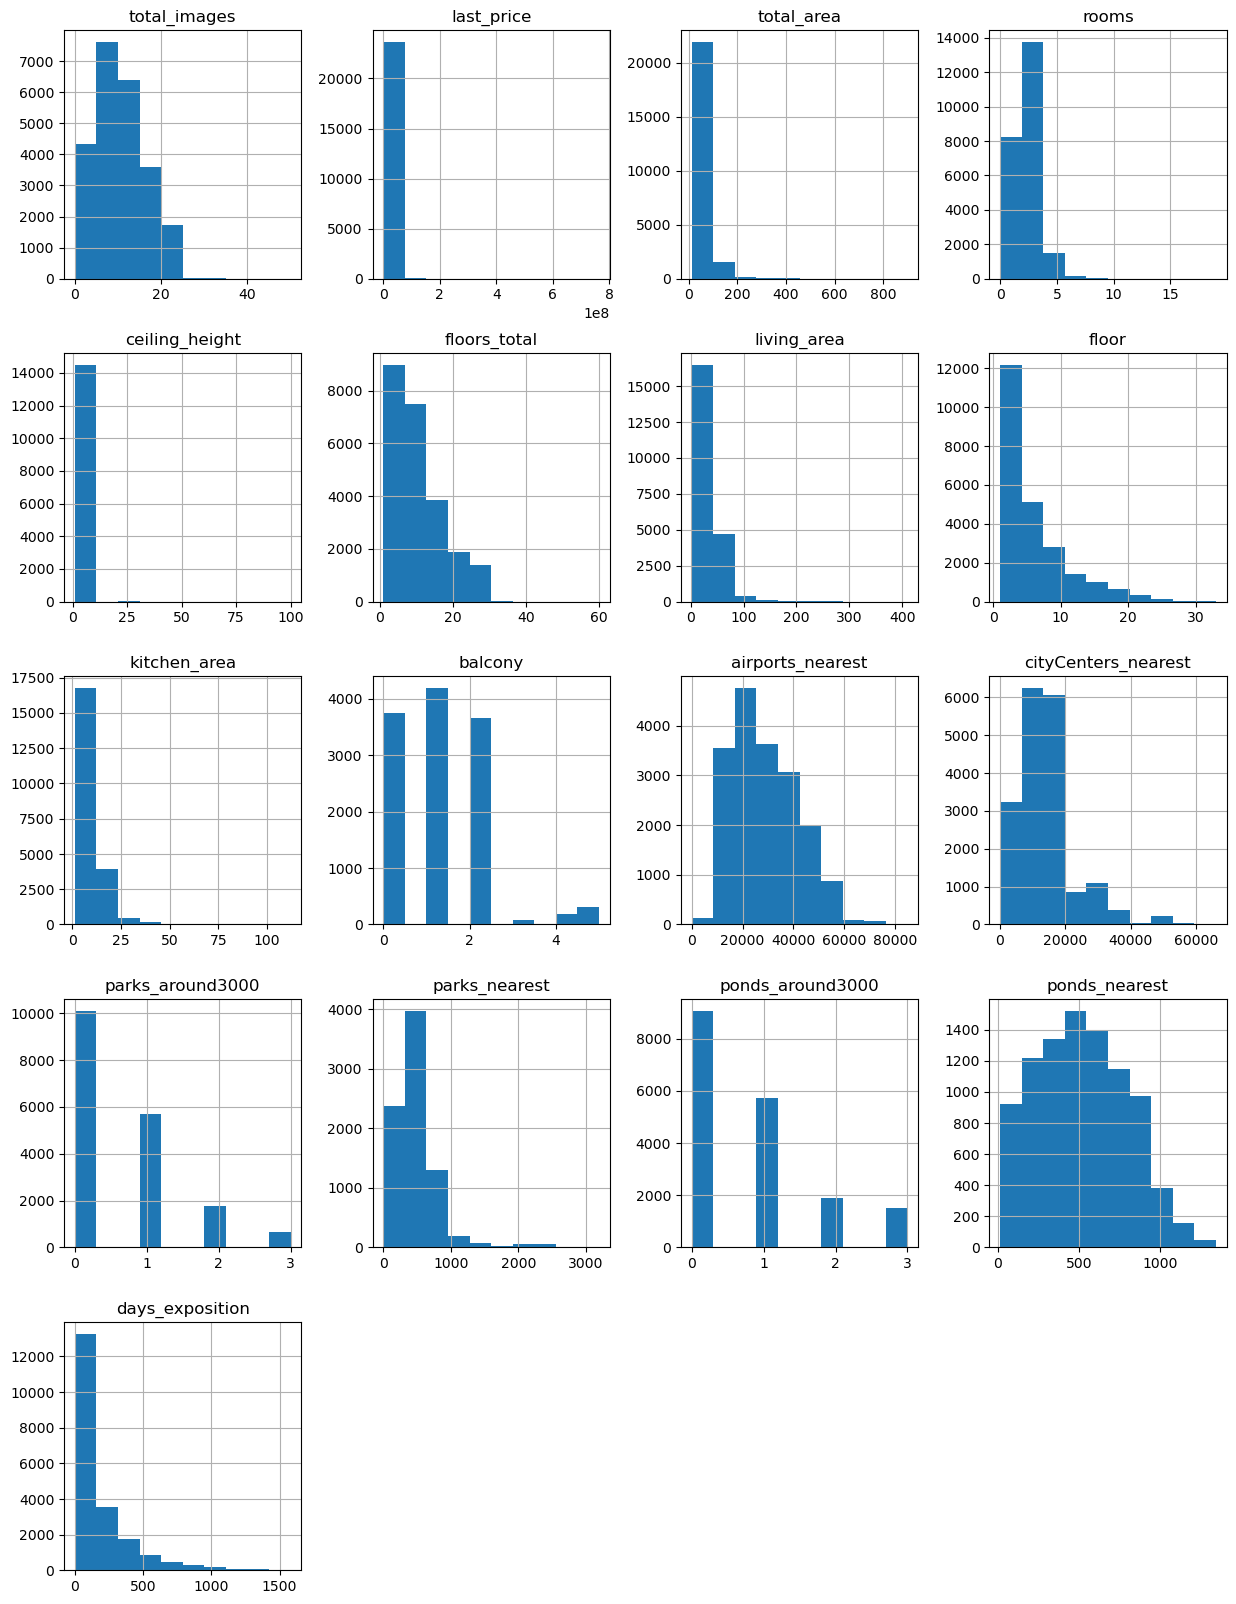

In [4]:
data.hist(figsize=(15, 20));

При первичном анализе датафрейма обнаружены ошибки в навании столбцов. Так столбец cityCenters_nearest необходимо привести к змеиному регистру. Для дальнейшей корректной работы с данными в столбцах is_apartment, balcony, first_day_exposition необходимо изменить типы данных. Наличие явных дубликатов не выявлено. В столбцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition имеются пропуски.

Из анализа гистограмм так же видно, что в данных есть значения, которые сильно выбиваются из общего числа данных.

- цена квартиры  80 млн. руб.
- общая площадь квартиры более 800 кв м
- количество комнат более 15
- высота потолков 100 метров
- жилая площадь более 400 кв м
- площадь кухни более 100 кв м
- наличие более 4-х балконов

### Предобработка данных

#### Найдем и изучим пропущенные значения в столбцах

In [5]:
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Многие столбцы имеют пропуски. Причины может быть две: некорректная выгрузка или пользователь не указал данные при размещении объявления.

В столбце balcony пропуски, заменим на 0, так как скорее всего там где пропуск балкона нет.
Похожая ситуация с парками и водоемами. Поэтому заменим пропуски в столбцах parks_around3000 и ponds_around3000 на 0.

В столбце locality_name заменим пропуски на unknow.

In [6]:
data['balcony']          = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['locality_name']    = data['locality_name'].fillna('unknow')
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].mean()) # заполним пропуски в высоте потолков на среднее значение
data['ceiling_height'].isna().sum()                # проверим наличие пропусков в высоте потолков


0

#### Рассмотрим типы данных в каждом столбце

Анализ столбцов:

cityCenters_nearest - привести к "змеиному регистру"

is_apartment - признак аппартамента, изменить формат столбца на логический, так как это признак, он или True или False. 

balcony - приведем к целочисленному типу.

first_day_exposition - дата первой публикации, изменить формат столбца на date, что бы можно было работать с датами.





In [7]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'}) # меняем название столбца
data['is_apartment'] = data['is_apartment'].astype('bool')                 # меняем тип на логический
data['balcony']      = data['balcony'].astype('int')                       # меняем тип на целый
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S') #меняем тип 
#data.info()


#### Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты

In [8]:
print(len(data['locality_name'].unique())) # 365 уникальных значений. ищем дубликаты

# найдено 3 неявных дубликата. избавляемся от них
data.loc[data['locality_name'] == 'поселок Кобралово', 'locality_name'] ='посёлок Кобралово'
data.loc[data['locality_name'] == 'поселок Пансионат Зелёный Бор', 'locality_name'] = 'посёлок Пансионат Зелёный Бор'
data.loc[data['locality_name'] == 'поселок Бугры', 'locality_name'] = 'посёлок Бугры'
len(data['locality_name'].unique())        # проверяем 
#data.head()

365


362

#### Найдем и устраним редкие и выбивающиеся значения. Посмотрим уникальные значения значения высоты потолков

In [9]:
data['ceiling_height'].sort_values(ascending=False).unique()

array([100.       ,  32.       ,  27.5      ,  27.       ,  26.       ,
        25.       ,  24.       ,  22.6      ,  20.       ,  14.       ,
        10.3      ,   8.3      ,   8.       ,   6.       ,   5.8      ,
         5.6      ,   5.5      ,   5.3      ,   5.2      ,   5.       ,
         4.9      ,   4.8      ,   4.7      ,   4.65     ,   4.5      ,
         4.45     ,   4.4      ,   4.37     ,   4.3      ,   4.25     ,
         4.2      ,   4.19     ,   4.15     ,   4.14     ,   4.1      ,
         4.06     ,   4.       ,   3.98     ,   3.95     ,   3.93     ,
         3.9      ,   3.88     ,   3.87     ,   3.86     ,   3.85     ,
         3.84     ,   3.83     ,   3.82     ,   3.8      ,   3.78     ,
         3.76     ,   3.75     ,   3.7      ,   3.69     ,   3.68     ,
         3.67     ,   3.66     ,   3.65     ,   3.63     ,   3.62     ,
         3.6      ,   3.59     ,   3.58     ,   3.57     ,   3.56     ,
         3.55     ,   3.54     ,   3.53     ,   3.52     ,   3.5

Значения 24, 25, 27, 27.5, и 32 слишком велики и скорее всего при вызрузке были в 10 раз меньше, 
поэтому приведем их к предполагаемому значению. 

In [10]:
data['ceiling_height'].count()

23699

In [11]:
data.loc[(data['ceiling_height'] >= 24) & (data['ceiling_height'] <= 32), 'ceiling_height'] = \
                                           data.loc[data['ceiling_height'] >= 24,'ceiling_height']/10


Изучим аномальность значений высоты потолков.
Уберем очень малые и очень большие значения высоты потолков и построим диаграмму размаха

0.9996624330140512

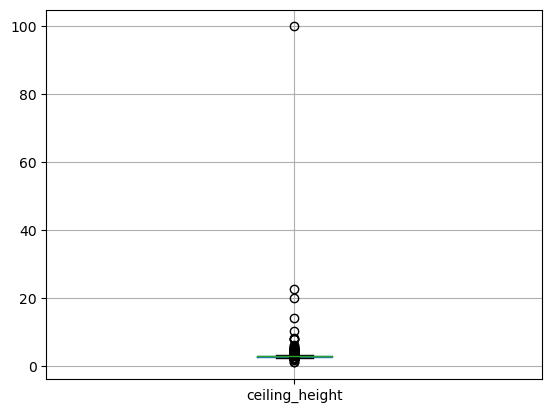

In [12]:
data.boxplot('ceiling_height'); # постороим диаграмму размаха
data_ceiling_height_new = data[(data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 10)] 
data_ceiling_height_new.shape[0]/ data.shape[0] # отбросили менее 1% данных


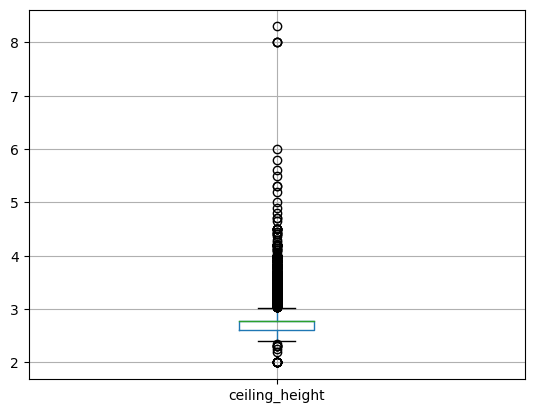

In [13]:
data_ceiling_height_new.boxplot('ceiling_height'); # постороим диаграмму размаха без аномальных значений

In [14]:
data = data[(data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 10)] # отбросим аномальные значения 
                                                                            # в основном датафрейме


Изучим аномалии в значениях стоимости квартиры

0.9837068929129206

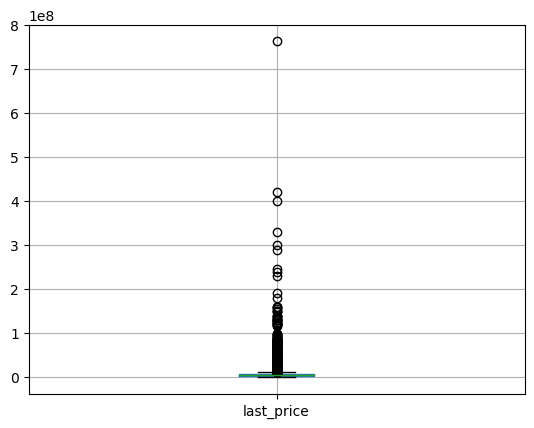

In [15]:
data.boxplot('last_price'); # постороим диаграмму размаха
data_last_price_new = data[(data['last_price'] >= 1000000) & (data['last_price'] <= 45000000)] 
data_last_price_new.shape[0]/ data.shape[0] # отбросили менее 2% данных


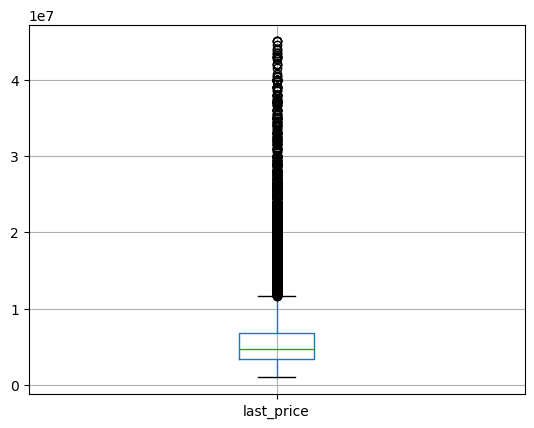

In [16]:
data_last_price_new.boxplot('last_price'); # постороим диаграмму размаха без аномальных значений

In [17]:
data = data[(data['last_price'] >= 1000000) & (data['last_price'] <= 45000000)] # отбросим аномальные значения 
                                                                                # в основном датафрейме

Изучим аномалии значений количества комнат

0.9989701780733748

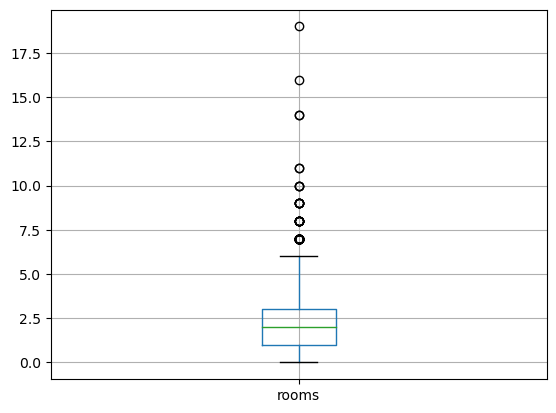

In [18]:
data.boxplot('rooms'); # постороим диаграмму размаха
data_rooms_new = data[(data['rooms'] >= 0) & (data['rooms'] <= 7)] 
data_rooms_new.shape[0]/ data.shape[0] # отбросили менее 2% данных

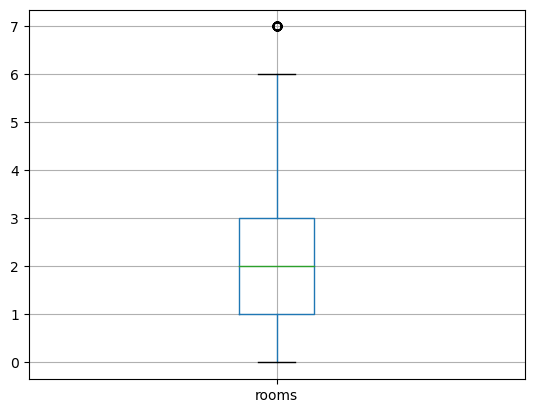

In [19]:
data_rooms_new.boxplot('rooms');

In [20]:
data = data[(data['rooms'] >= 1) & (data['rooms'] <= 7)]  # отбросим аномальные значения в основном датафрейме

Изучим аномальность значений общей площади квартиры

0.9940656675041151

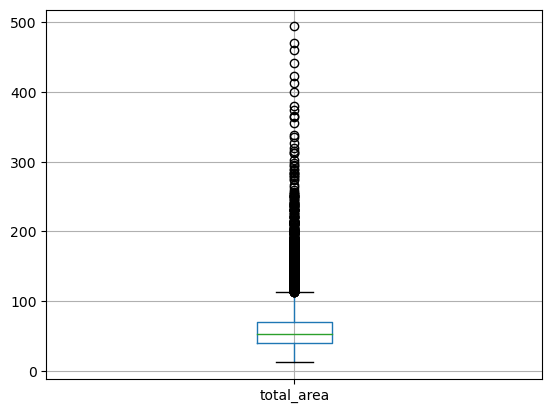

In [21]:
data.boxplot('total_area'); # постороим диаграмму размаха
data_total_area_new = data[(data['total_area'] >= 20) & (data['total_area'] <= 200)] 
data_total_area_new.shape[0]/ data.shape[0] # отбросили менее 1% данных

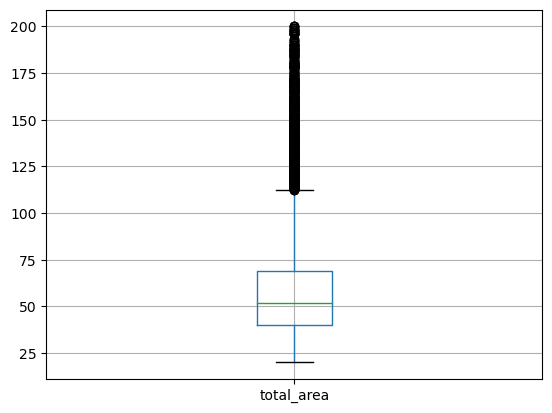

In [22]:
data_total_area_new.boxplot('total_area');

In [23]:
data = data[(data['total_area'] >= 20) & (data['total_area'] <= 200)] # отбросим аномальные значения в основном датафрейме

В данном разделе были построены диаграммы размаха и отброшены аномальные значения.
Для высоты потолков оставили значения от 2 до 10 метров, для цены квартиры от 10 до 45 млн. руб., для количества комнат от 1 до 7, для общей площади от 20 до 200 кв метров. При этом отбросили менее 1% данных.

### Посчитайте и добавьте в таблицу новые столбцы

Добавляем в таблицу новые столбцы:
цена одного квадратного метра;
день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
месяц публикации объявления;
год публикации объявления;
тип этажа квартиры (значения — «‎первый», «последний», «другой»);
расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).


In [24]:
data['price_one_metr'] = data['last_price']/data['total_area']
data['day_number_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['month_number_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_number_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year
data[['price_one_metr','day_number_exposition','month_number_exposition','year_number_exposition']].head()
data.reset_index(drop=True).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_metr,day_number_exposition,month_number_exposition,year_number_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.700000,16.0,51.0,8,True,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.771499,11.0,18.6,1,True,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.771499,5.0,34.3,4,True,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015
3,2,10000000.0,100.0,2018-06-19,2,3.030000,14.0,32.0,13,True,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018
4,10,2890000.0,30.4,2018-09-10,1,2.771499,12.0,14.4,5,True,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0,95065.789474,0,9,2018


Напишем функцию для определения типа этажа квартиры и добавим это значение в новый столбец

In [25]:
def type_floor_flat(row):
    if row['floor'] == 1:
        return('первый')
    elif row['floor'] == row['floors_total']:
        return('последний')
    else:
        return('другой')
    
data['type_floor'] = data.apply(type_floor_flat, axis=1) 

Добавим столбец расстояния от квартиры до центра города в целых значениях

In [26]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest']/1000)

In [27]:
data['ceiling_height'].sort_values().unique()

array([2.       , 2.2      , 2.25     , 2.3      , 2.34     , 2.4      ,
       2.45     , 2.46     , 2.47     , 2.48     , 2.49     , 2.5      ,
       2.51     , 2.52     , 2.53     , 2.54     , 2.55     , 2.56     ,
       2.57     , 2.58     , 2.59     , 2.6      , 2.61     , 2.62     ,
       2.63     , 2.64     , 2.65     , 2.66     , 2.67     , 2.68     ,
       2.69     , 2.7      , 2.71     , 2.72     , 2.73     , 2.74     ,
       2.75     , 2.76     , 2.77     , 2.7714989, 2.78     , 2.79     ,
       2.8      , 2.81     , 2.82     , 2.83     , 2.84     , 2.85     ,
       2.86     , 2.87     , 2.88     , 2.89     , 2.9      , 2.91     ,
       2.92     , 2.93     , 2.94     , 2.95     , 2.96     , 2.97     ,
       2.98     , 2.99     , 3.       , 3.01     , 3.02     , 3.03     ,
       3.04     , 3.05     , 3.06     , 3.07     , 3.08     , 3.09     ,
       3.1      , 3.11     , 3.12     , 3.13     , 3.14     , 3.15     ,
       3.16     , 3.17     , 3.18     , 3.2      , 

### Проведите исследовательский анализ данных

#### Изучение  параметров объектов:

Построим отдельные гистограммы для каждого из этих параметров. 

##### Изучим общую площадь квартир, построив гистограммы

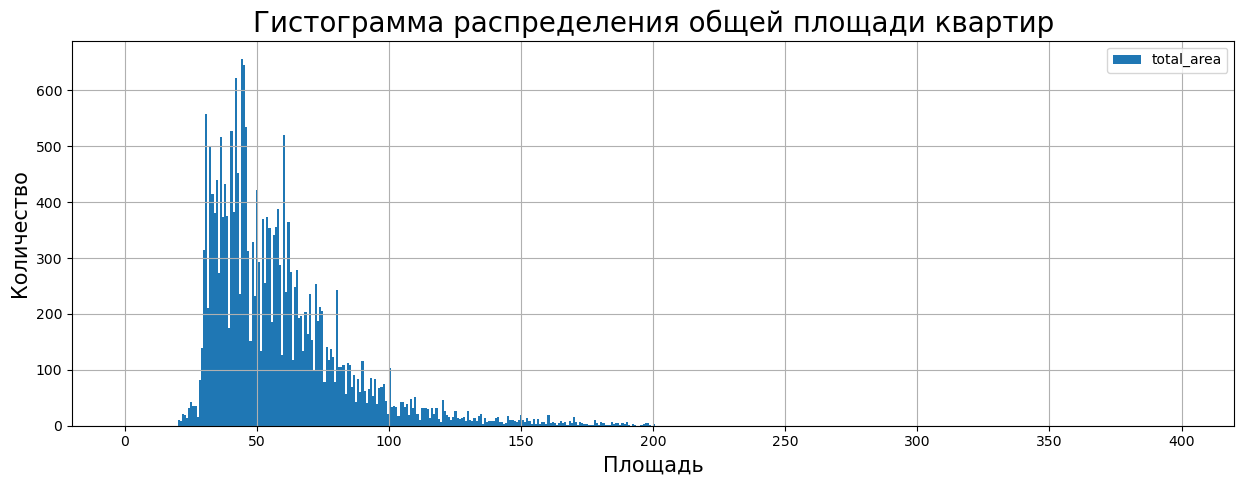

In [28]:
data.hist('total_area', bins=500, grid=True,range=(0,400), legend=True, figsize=(15,5));
plt.title('Гистограмма распределения общей площади квартир', fontsize=20)
plt.xlabel('Площадь', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.show();

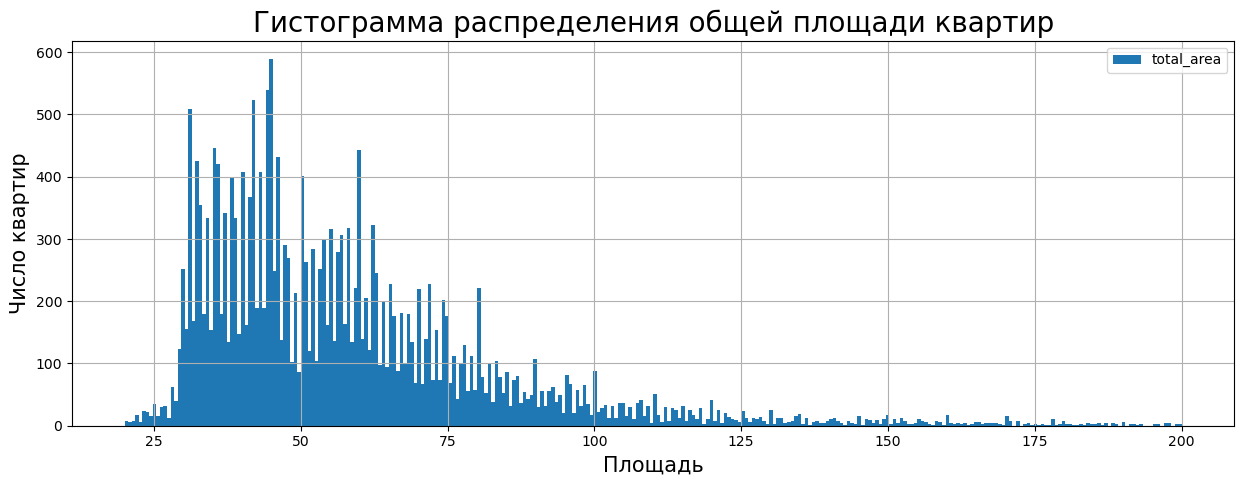

In [29]:
data.hist('total_area', bins=300, grid=True,range=(20,200), legend=True, figsize=(15,5))
plt.title('Гистограмма распределения общей площади квартир', fontsize=20)
plt.xlabel('Площадь', fontsize=15)
plt.ylabel('Число квартир', fontsize=15)
plt.show();

Основная масса квартир имеет площать от 25 до 125 квадратных метров.
Больше всего квартир с площадью от 40 до 50 квадраьных метров  

##### Изучим жилую площадь квартир, построив гистограммы

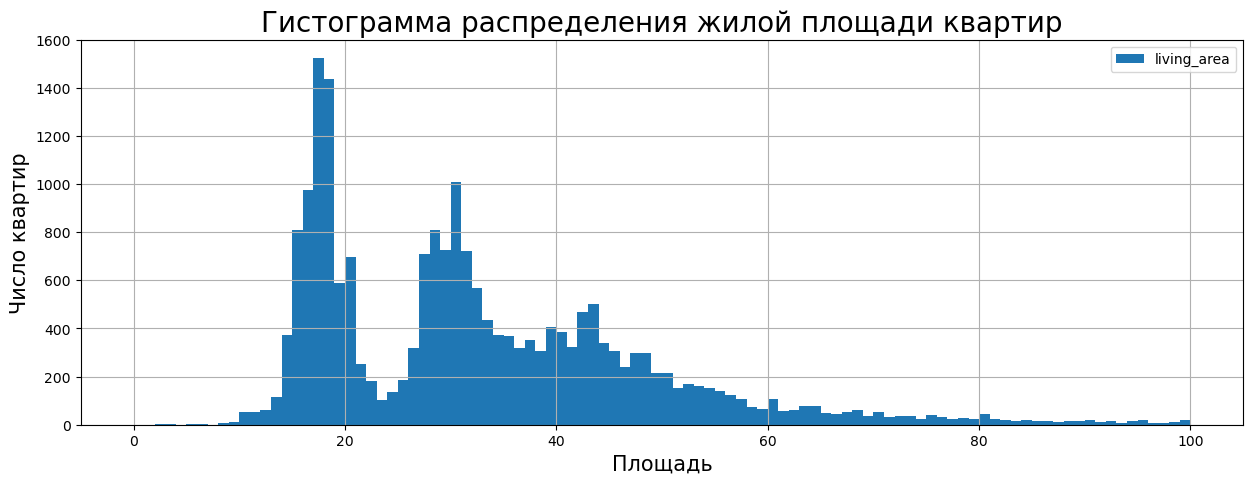

In [30]:
data.hist('living_area', bins=100, grid=True, range=(0,100), legend=True, figsize=(15,5))
plt.title('Гистограмма распределения жилой площади квартир', fontsize=20)
plt.xlabel('Площадь', fontsize=15)
plt.ylabel('Число квартир', fontsize=15)
plt.show();

Количество квартир по жилой площади имеет два пика , первый-от 15 кв м до 20 кв м, второй- от 25 кв м до 30.
В целом основная масса квартир по жилой площади находится в диапазоне от 15 кв м до 60 кв м

##### Изучим площадь кухни

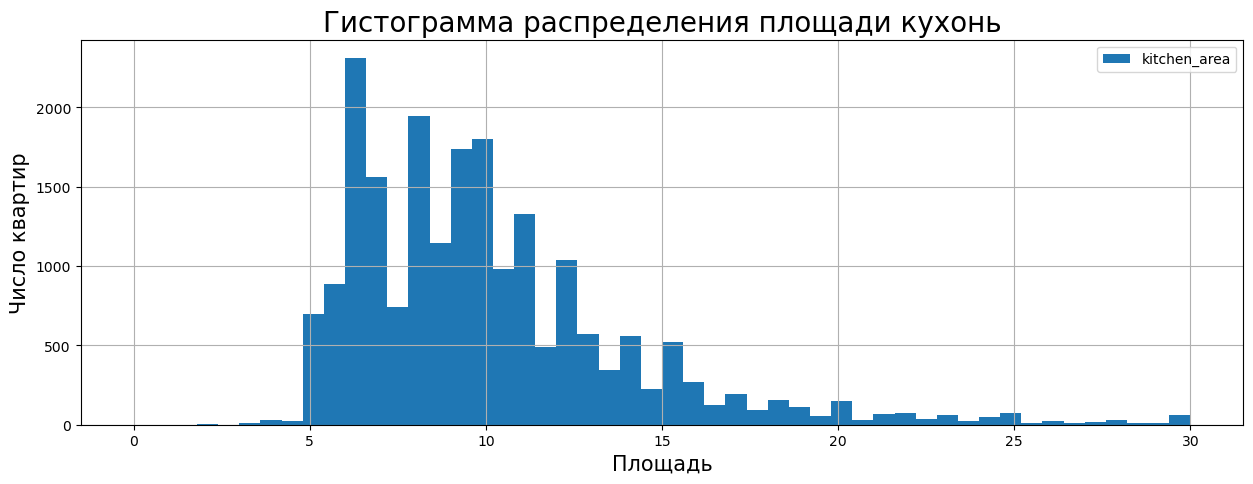

In [31]:
data.hist('kitchen_area', bins=50, range=(0,30), grid=True, legend=True, figsize=(15,5))
plt.title('Гистограмма распределения площади кухонь', fontsize=20)
plt.xlabel('Площадь', fontsize=15)
plt.ylabel('Число квартир', fontsize=15)
plt.show();

##### Изучим цену объекта

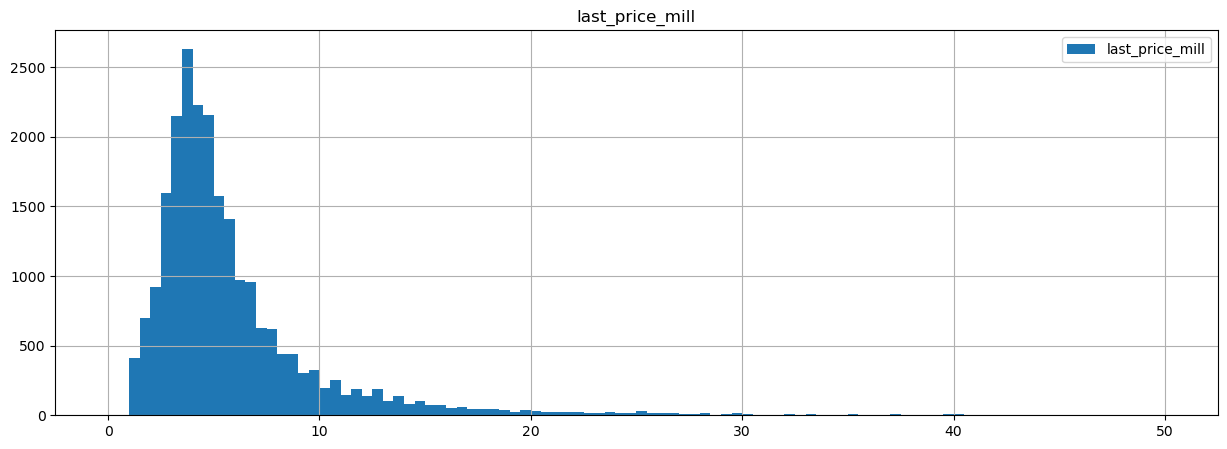

In [32]:
data['last_price_mill'] = data['last_price']/1000000 # добавим столбец цена в млн руб и построим по нему гистограмму
data.hist('last_price_mill', bins=100, range=(0,50), figsize=(15,5), grid=True, legend=True);

Больше всего квартир с стоимостью от 2 до 10 млн. руб.

#####  Изучим объекты по количеству комнат

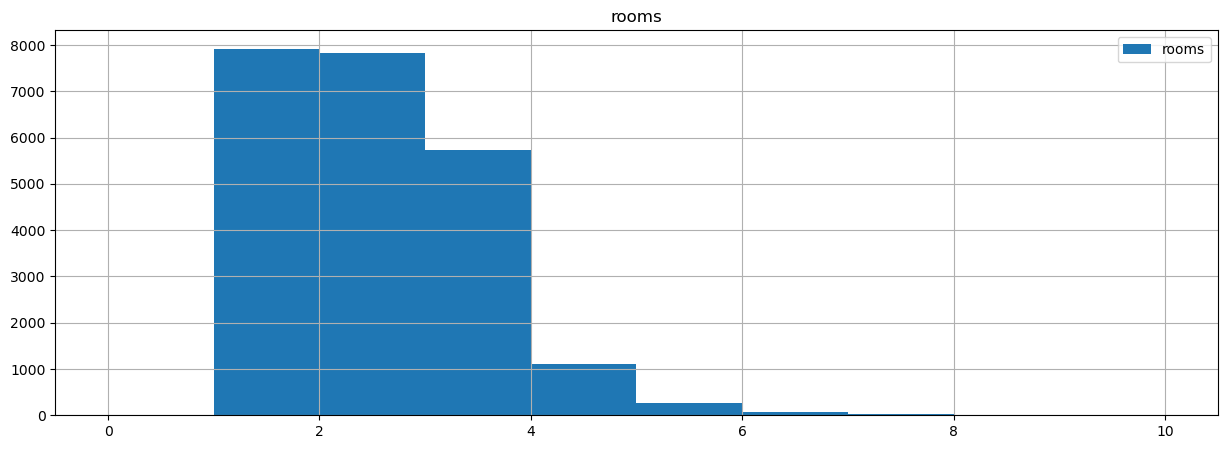

In [33]:
data.hist('rooms', bins=10, range=(0,10), figsize=(15,5), grid=True, legend=True);

Преобладают 2,3 и 4-х комнатные квартиры

##### Изучим высоту потолков

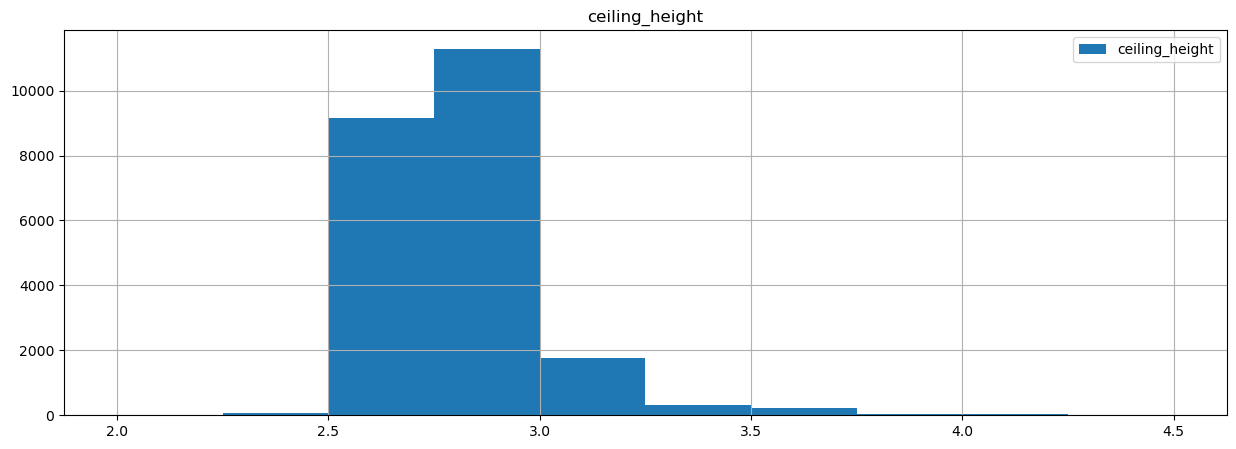

In [34]:
data.hist('ceiling_height', bins=10, range=(2,4.5), figsize=(15,5), grid=True, legend=True);

Большинство квартир имеет высоту потолков от 2,5 до 2,75 метров

##### Изучим этажность квартир

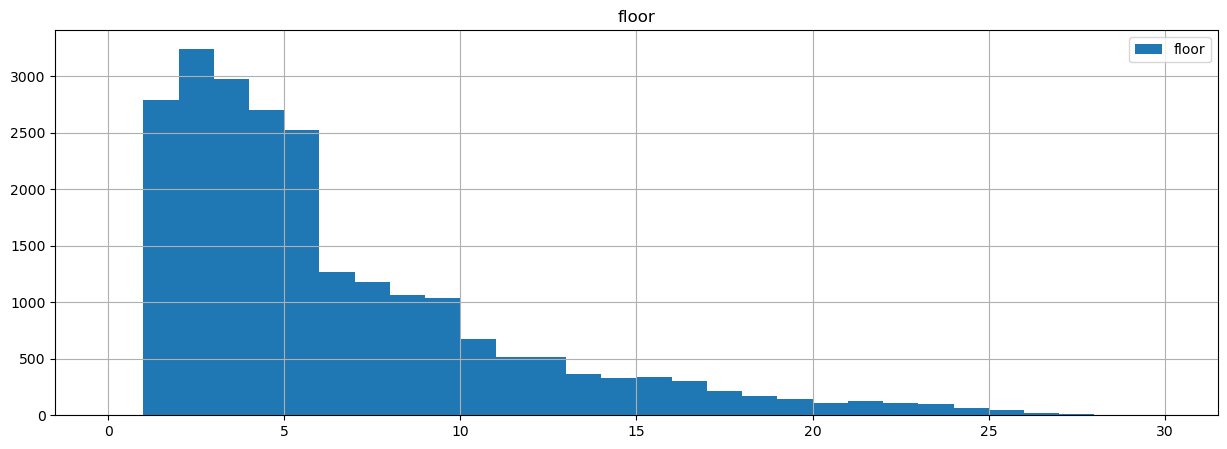

In [35]:
data.hist('floor', bins=30, range=(0,30), figsize=(15,5), grid=True, legend=True);


Преобладают квартиры, находящиеся в пятиэтажных домах

##### Изучим тип этажа квартиры («первый», «последний», «другой»);

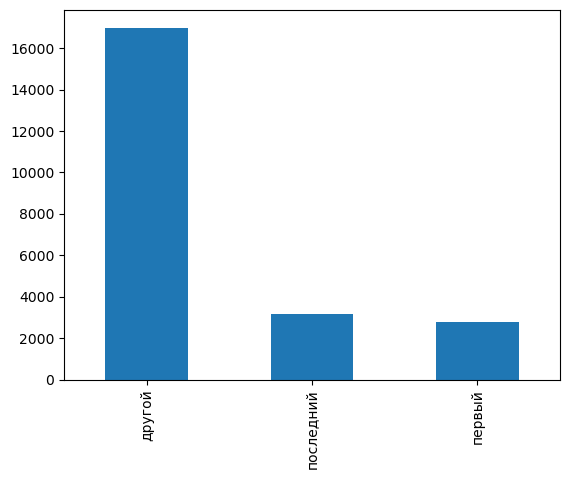

In [36]:
#data.hist('type_floor')
data['type_floor'].value_counts().plot(kind='bar');


Большинство квартир располагается не на первом и не на последнем этаже

##### Изучим параметр всего этажей в доме

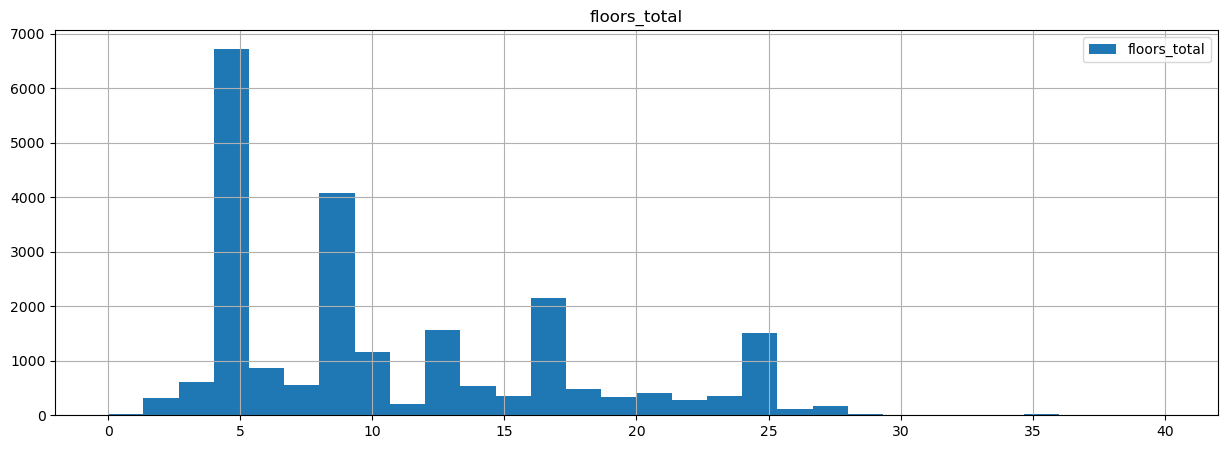

In [37]:
data.hist('floors_total', bins=30, range=(0,40), figsize=(15,5), grid=True, legend=True);

Наиболее распространенны 5-ти и 9-ти этажные дома

#####  Изучим расстояние до центра города в метрах;


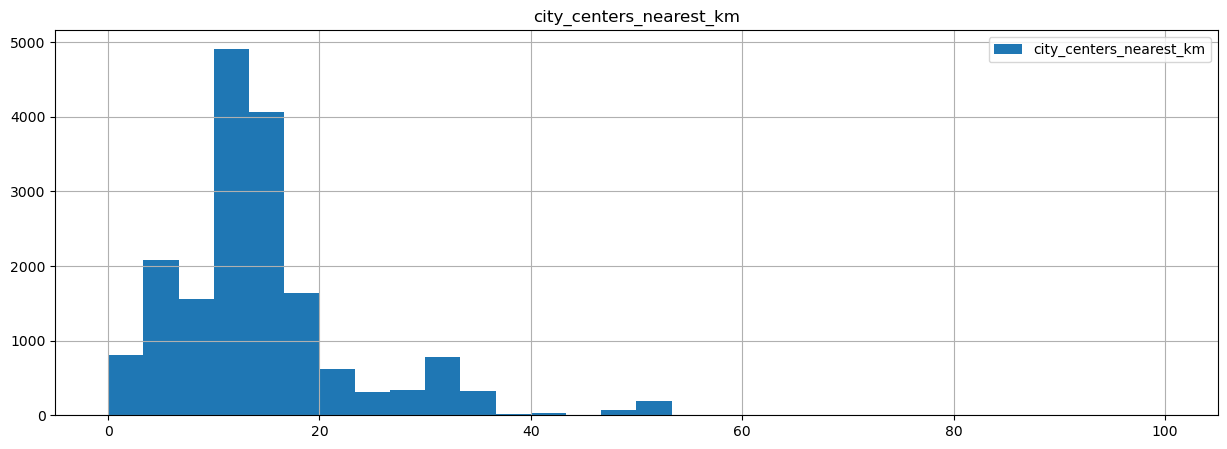

In [38]:
data.hist('city_centers_nearest_km', bins=30, range=(0,100), figsize=(15,5), grid=True, legend=True);

 Большинство квартир располагается в радиусе 20-ти километров от центра города

##### Изучим расстояние до ближайшего аэропорта

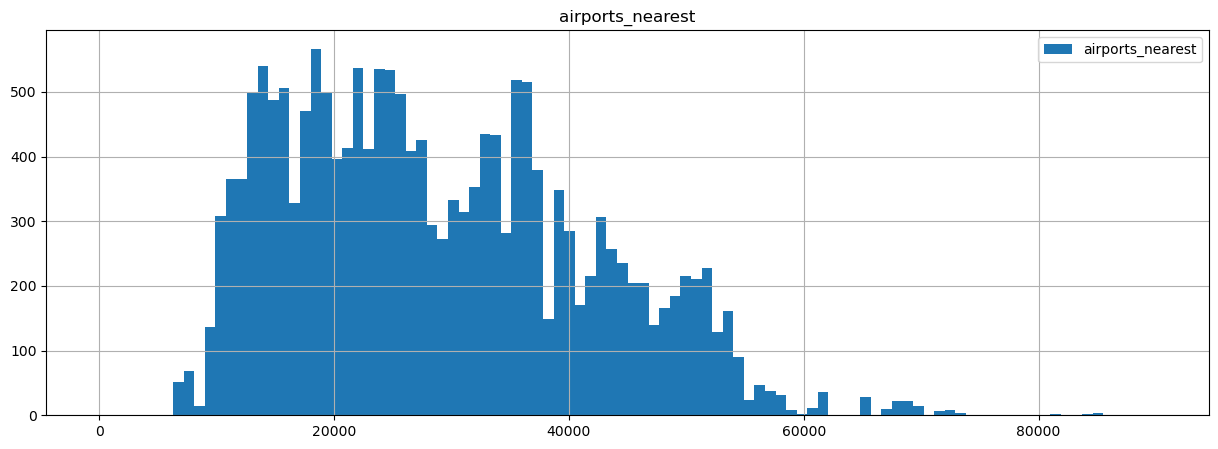

In [39]:
data.hist('airports_nearest', bins=100, range=(0,90000), figsize=(15,5), grid=True, legend=True);


Большинство квартир находятся на расстоянии от 10 до 55 км от аэропорта

##### Изучим расстояние до ближайшего парка

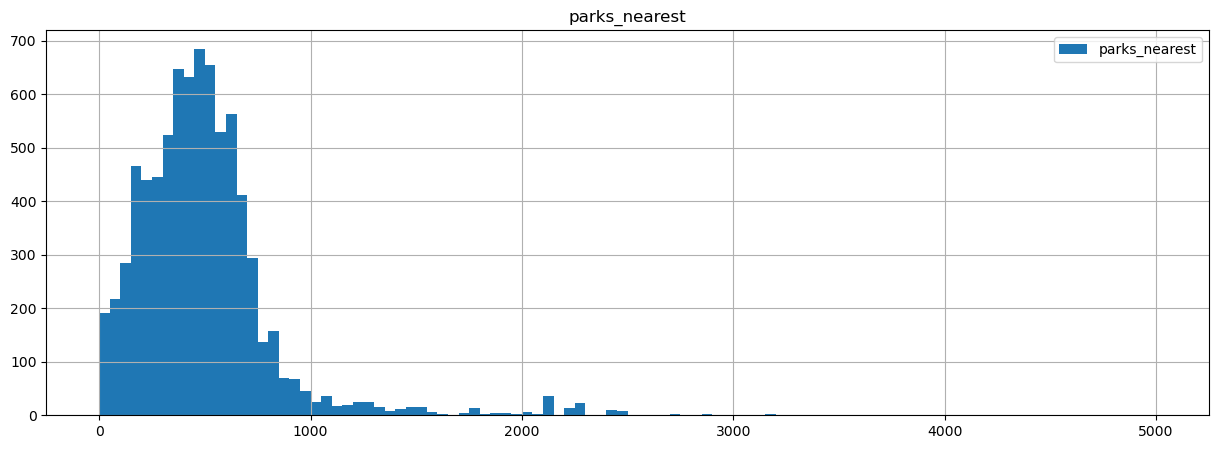

In [40]:
data.hist('parks_nearest', bins=100, range=(0,5000), figsize=(15,5), grid=True, legend=True);

Большинство квартир имеет парк к радиусе одного километра

##### Изучим день и месяц публикации объявления

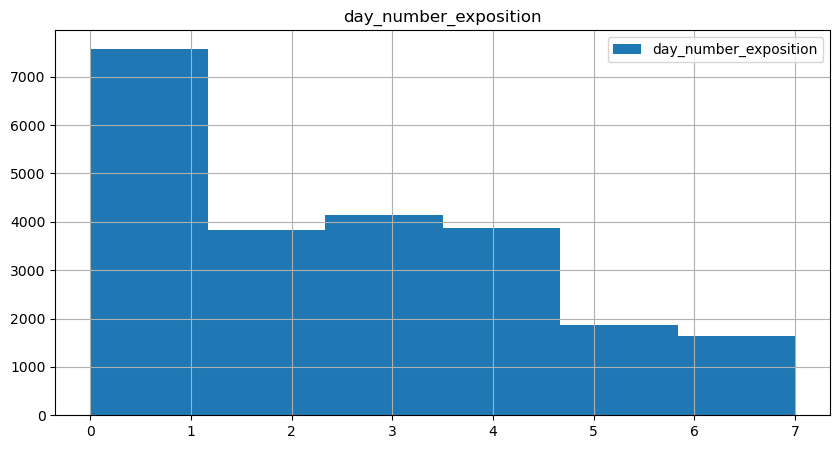

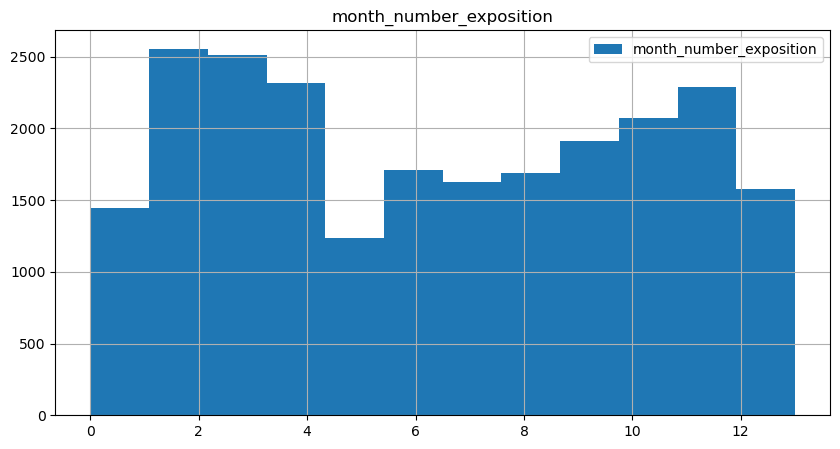

In [41]:
data.hist('day_number_exposition', bins=6, range=(0,7), figsize=(10,5), grid=True, legend=True);

data.hist('month_number_exposition', bins=12, range=(0,13), figsize=(10,5), grid=True, legend=True);

Объявления публикуются большей части в буднии дни. Самое большое количество объявлений публикуется в ноябре, летом наблюдается снижение активности по подаче объявлений.

#### Изучим , как быстро продавались квартиры 
(столбец days_exposition). 
Этот параметр показывает, сколько дней было размещено каждое объявление.
Постройте гистограмму.
Посчитайте среднее и медиану.
В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

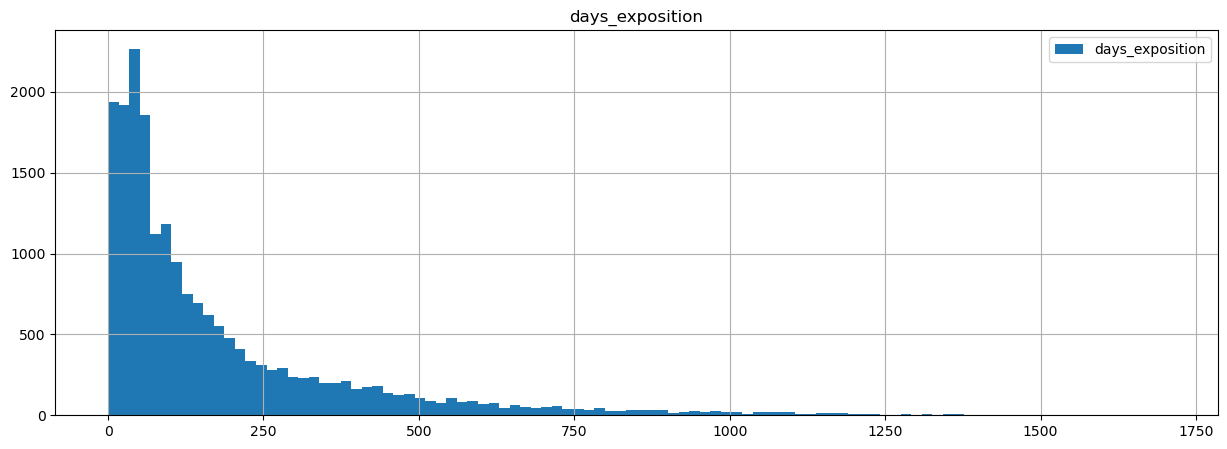

In [42]:
data.hist('days_exposition', bins=100, range=(0,1700), figsize=(15,5), grid=True, legend=True);

In [43]:
data['days_exposition'].mean()

180.25198512413309

In [44]:
data['days_exposition'].median()

95.0

Медианое значение длительности продажи квартиры составляет 95 дней. Наличие малого числа очень долгих продаж сдвигает среднее время продажи на 179 дней. Быстрые продажи, это продажи в первые 100 дней, долгие - более 250 дней

#### Изучим какие факторы больше всего влияют на общую (полную) стоимость объекта
общая площадь; 

жилая площадь;

площадь кухни;

количество комнат;

этажа, на котором расположена квартира (первый, последний, другой);

дата размещения (день недели, месяц, год).

Построим графики, которые покажут зависимость цены от указанных выше параметров. 
Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.


##### Построим график зависимости цены квартиры от ее общей площади и посчитаем коэффициент корреляции Пирсона

0.7719968557529913

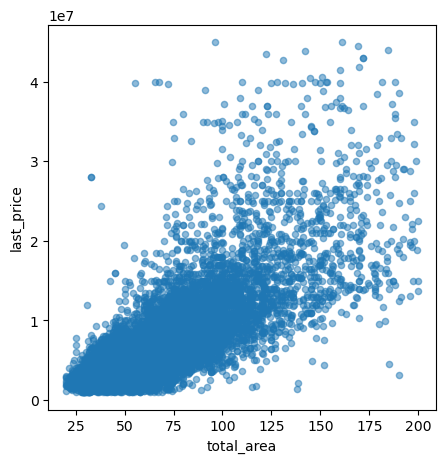

In [45]:
data.sort_values('last_price').plot(
    x='total_area', 
    y='last_price', 
    kind='scatter', 
    figsize=(5,5),
    alpha=0.5
    );
data['total_area'].corr(data['last_price'])

При увеличении площади квартиры увеличивается ее стоимость. Так же об этом нам говорит коэффициент корреляции. Его значение, близкое 0,76 показывает достаточно сильную зависимость

##### Построим график зависимости цены квартиры от ее общей жилой площади и посчитаем коэффициент корреляции Пирсона

0.658430248196069

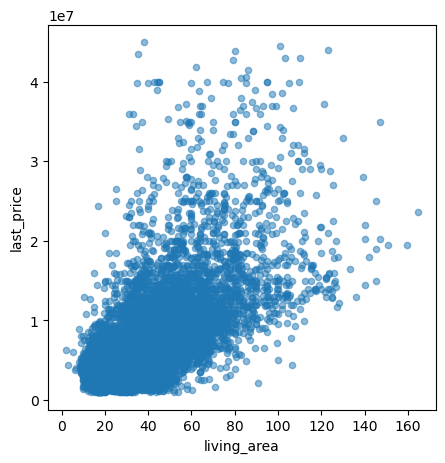

In [46]:
data.sort_values('living_area').plot(
    x='living_area', 
    y='last_price', 
    kind='scatter', 
    figsize=(5,5),
    alpha=0.5
    );
data['living_area'].corr(data['last_price'])

При увеличении жилой площади квартиры увеличивается ее стоимость. Коэффициент корреляции равен 0,65 что показывает среднюю зависимость

##### Построим график зависимости цены квартиры от площади кухни и посчитаем коэффициент корреляции Пирсона

0.590943273315567

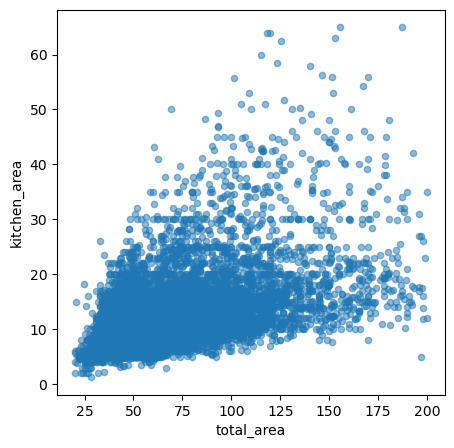

In [47]:
data.sort_values('kitchen_area').plot(
    x='total_area', 
    y='kitchen_area', 
    kind='scatter', 
    figsize=(5,5),
    alpha=0.5
    );
data['kitchen_area'].corr(data['last_price'])

При увеличении площади кухни стоимость квартиры увеличивается. Исходя из коэффициента корреляции 0,58 зависимость слабая

##### Построим график зависимости цены квартиры от количества комнат и посчитаем коэффициент корреляции Пирсона

0.47352519474978905

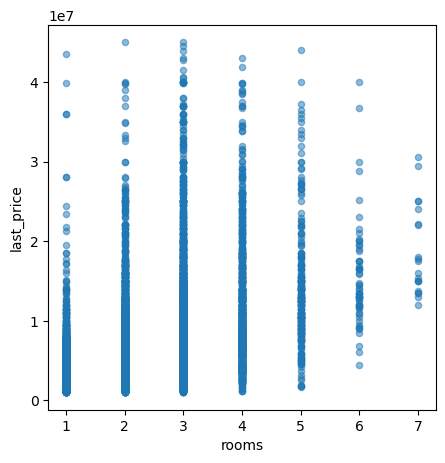

In [48]:
data.sort_values('rooms').plot(
    x='rooms', 
    y='last_price', 
    kind='scatter', 
    figsize=(5,5),
    alpha=0.5
    );
data['rooms'].corr(data['last_price'])

Чем больше в квартире комнат, тем ее стоимость выше, но зависимость слабая

##### Построим график зависимости цены квартиры от типа этажа, на котором она находится (первый, последний млм другой)

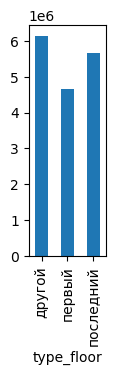

In [49]:
data_type_floor = data.pivot_table(index='type_floor', values='last_price');
data_type_floor['type_floor'] = data_type_floor.index
data_type_floor

data_type_floor.plot(
    x='type_floor', 
    y='last_price',
    kind='bar',     # scatter
    figsize=(1,3),
    legend=False    # уберем подпись гистограммы, так как мешает просмотру графика
    );


Средняя стоимость квартир с типом этажа "другой" выше чем с типом на "первом" и на "последнем". Самые дешевый квартиры на первом этаже.

##### Построим график зависимости цены квартиры от даты размещения объявления (дня недели, месяца, года)

###### Зависимость от даты размещения

<AxesSubplot:xlabel='first_day_exposition', ylabel='last_price'>

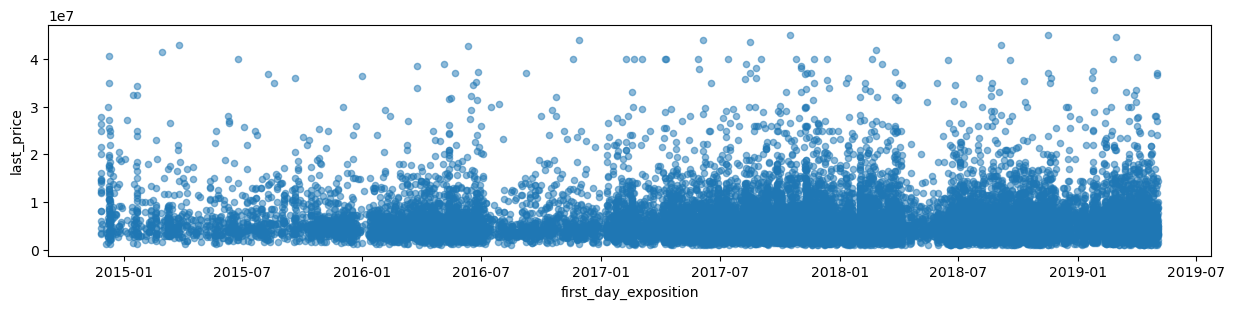

In [50]:
data.sort_values('first_day_exposition').plot( # посчитаем по всем значениям
    x='first_day_exposition', 
    y='last_price', 
    kind='scatter', 
    figsize=(15,3),
    alpha=0.5
    )

In [51]:
data_date = data.pivot_table(index='first_day_exposition'\
                             ,values='last_price'\
                             ,aggfunc='median')\
                             .sort_values('first_day_exposition') # посчитаем по медианым значениям
data_date['first_day_exposition'] = data_date.index
#data_date.head()

<AxesSubplot:xlabel='first_day_exposition', ylabel='last_price'>

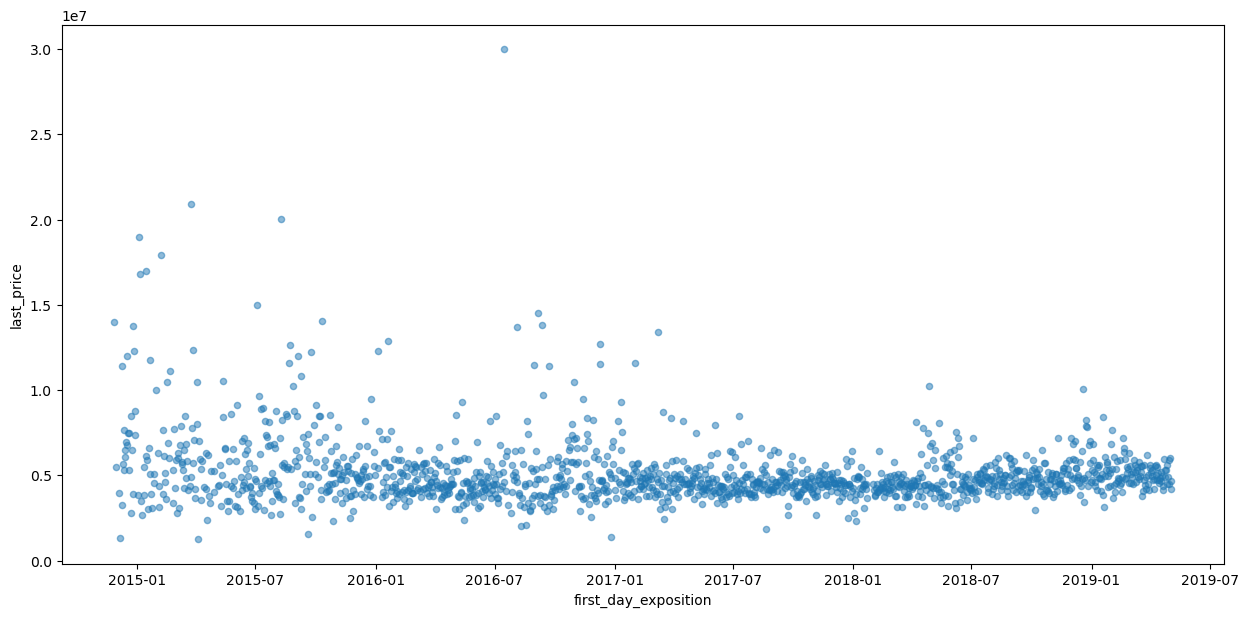

In [52]:
data_date.plot(
    x='first_day_exposition', 
    y='last_price', 
   kind='scatter', 
   figsize=(15,7),
   alpha=0.5
   )

 С 2014 по 2016 года количество объявлений более дорогих квартир было опубликовано больше

###### Зависимость от дня недели

In [53]:
data_day = data.pivot_table(index='day_number_exposition', values='last_price', aggfunc='median')\
                 .sort_values('day_number_exposition')
data_day['day_number_exposition'] = data_day.index
data_day




,last_price,day_number_exposition
day_number_exposition,,
0,4650000.0,0
1,4750000.0,1
2,4700000.0,2
3,4650000.0,3
4,4600000.0,4
5,4600000.0,5
6,4550000.0,6


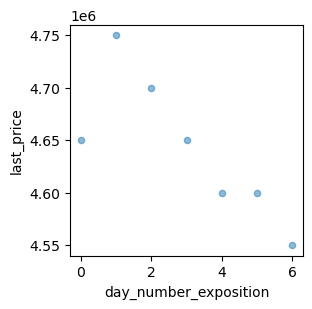

In [54]:
data_day.plot(
                x='day_number_exposition', 
                y='last_price', 
                kind='scatter', 
                figsize=(3,3),
                alpha=0.5
               );

В выходные размещают объявления с более дешевыми квартирами

###### Зависимость от месяца

In [55]:
data_month = data.pivot_table(index='month_number_exposition', values='last_price', aggfunc='median')\
                 .sort_values('month_number_exposition')
data_month['month_number_exposition'] = data_month.index
data_month

,last_price,month_number_exposition
month_number_exposition,,
1,4600000.0,1
2,4650000.0,2
3,4697500.0,3
4,4800000.0,4
5,4550000.0,5
6,4400000.0,6
7,4650000.0,7
8,4600000.0,8
9,4700000.0,9


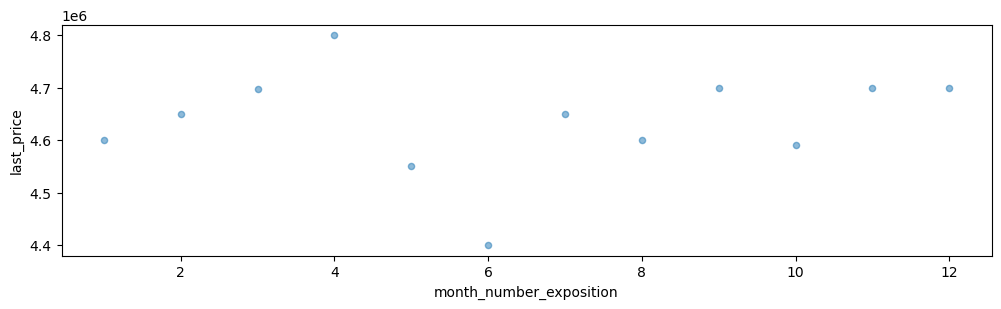

In [56]:
data_month.plot(
                x='month_number_exposition', 
                y='last_price', 
                kind='scatter', 
                figsize=(12,3),
                alpha=0.5
            );

Самые дешевый квартиры опубликованы в июне.

###### Зависимость от года

In [57]:
data_year = data.pivot_table(index='year_number_exposition', values='last_price', aggfunc='median')\
                 .sort_values('year_number_exposition')
data_year['year_number_exposition'] = data_year.index
data_year

,last_price,year_number_exposition
year_number_exposition,,
2014,7500000.0,2014
2015,5250000.0,2015
2016,4500000.0,2016
2017,4500000.0,2017
2018,4600000.0,2018
2019,5100000.0,2019


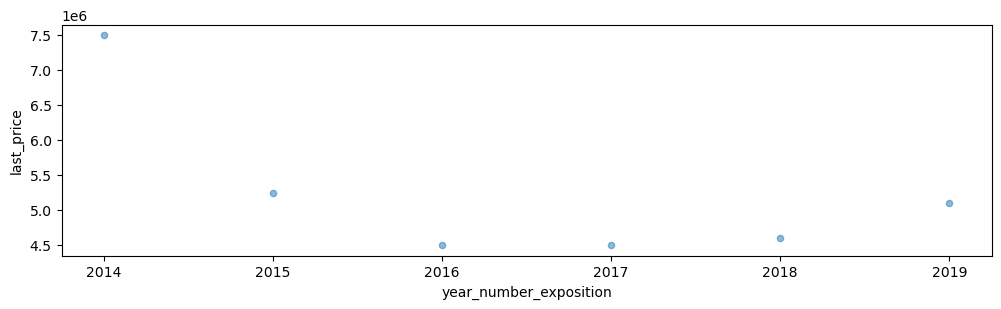

In [58]:
data_year.plot(
    x='year_number_exposition', 
    y='last_price', 
    kind='scatter', 
    figsize=(12,3),
    alpha=0.5
    );

Самые дорогие квартиры опубликованы в 2014 году

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.        
Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.
Эти данные можно найти по имени в столбце locality_name.

In [59]:
data_mean = data.pivot_table(index='locality_name'\
                             , values='last_price'\
                             , aggfunc='count') # группируем по месту нахождения квартиры и находим 
                                                # их количество количество

data_mean.columns = ['count']                   # переименуем столбец
data_mean['locality_name'] = data_mean.index    # добавим столбец с локацией
#print(data_mean.sort_values('count', ascending=False).head(10)) # проверяли что выводит на экран


locality_name_top10 = data_mean.sort_values('count', ascending=False)\
                               .head(10)['locality_name']        # 10 населенных пунктов с наибольшим числом объявлений

data_top10 = data.query('locality_name in @locality_name_top10') # создаем датафрейм с 10 населенными
                                                                 # пунктами с наибольшим числом объявлений
data_top10.pivot_table(index='locality_name', values='price_one_metr')\
                     .sort_values('price_one_metr', ascending=False) # считаем среднее значение цены квадратного метра
                                                                     # в населенных 10 пунктах с наибольшим числом объявлений



,price_one_metr
locality_name,
Санкт-Петербург,111775.956592
Пушкин,103077.242205
деревня Кудрово,92297.218847
посёлок Парголово,90448.423806
посёлок Мурино,85031.776479
посёлок Шушары,78405.738420
Колпино,75333.295801
Гатчина,68935.194838
Всеволожск,68683.728439


In [60]:
locality_name_top10

locality_name
Санкт-Петербург        Санкт-Петербург
посёлок Мурино          посёлок Мурино
посёлок Шушары          посёлок Шушары
Всеволожск                  Всеволожск
Пушкин                          Пушкин
Колпино                        Колпино
посёлок Парголово    посёлок Парголово
Гатчина                        Гатчина
деревня Кудрово        деревня Кудрово
Выборг                          Выборг
Name: locality_name, dtype: object

Самая высокая стоимость квадратного метра из городов топ-10 по количеству объявлений в Санкт-Петербурге, самая низкая в Выборге

По полученным результатам видно, что общая стоимость квартиры больше зависит от общей площади, чем от жилой площади, площади кухни и количества комнат (видно по более высокому коэффциенту корреляции Пирсона, 0,76; 0,69; 0,59 и 0,47 соответственно) Чем больше общая площадь, жилая площадь, площадь кухни, количество комнат тем выше стоимость квартиры.
Таже на цену влияет этажность. Самые дешевые квартиры расположены на первом этаже, чуть дороже на последнем, и самые дорогие на других этажах.


В 2014 году средня стоимость квартир наибольшая. Если этот показатель отбросить, то заметим, что средня стоимость квартир плавно увеличивается от года к году. 

Самая дорогая недвижимость находиться в городе Санкт-Петербург.

#### Найдем квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [61]:
data_km = data.query('locality_name == "Санкт-Петербург"')
#data_x.pivot_trable(index='city_centers_nearest_km', values='last_price', aggfunc='median')
data_km = data_km.pivot_table(index='city_centers_nearest_km', values='last_price')
data_km.columns = ['price_km']

data_km['city_centers_nearest_km'] = data_km.index # приводим значения в столбце price_km к читаемому формату
pd.options.display.float_format ='{:,.3f}'.format

data_km

,price_km,city_centers_nearest_km
city_centers_nearest_km,,
0.000,"17,945,597.905",0.000
1.000,"12,201,491.012",1.000
2.000,"11,778,076.364",2.000
3.000,"9,972,495.121",3.000
4.000,"10,749,471.927",4.000
5.000,"11,183,035.705",5.000
6.000,"10,642,822.655",6.000
7.000,"10,828,132.233",7.000
8.000,"8,916,388.222",8.000


<AxesSubplot:xlabel='city_centers_nearest_km', ylabel='price_km'>

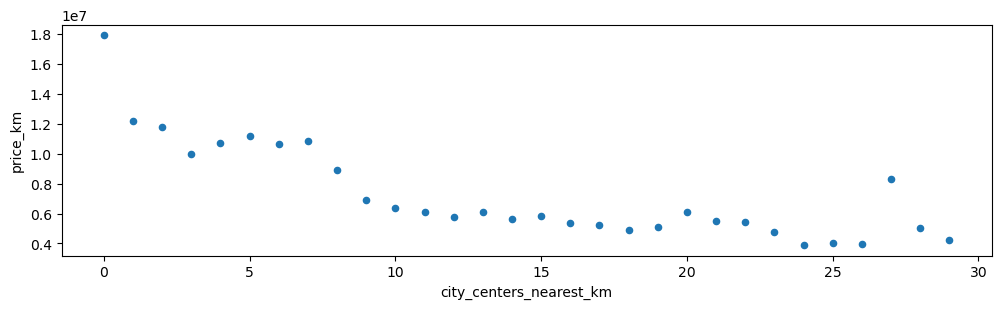

In [62]:
data_km.plot(
    x='city_centers_nearest_km', 
    y='price_km', 
    kind='scatter', 
    figsize=(12,3),
    )

Исходя из полученных данных видно, что самые дорогие квартиры находятся в центре города, самые дешевые на его окраинах. Чем больше расстояние от центра города, тем дешевле квартира. С 7 по 10 километр имеем резко низходящий участок графика, что дает нам понять что стоимость квартир падает и скорее всего здесь заканчивается центр города. Предположим что граница центра города находится на расстоянии 8 км от самого центра.

### Общий вывод

При первичном анализе датафрейма обнаружены ошибки в навании столбцов. Так столбец cityCenters_nearest приведен к змеиному регистру. Для дальнейшей корректной работы с данными в столбцах: 

- is_apartment, 
- balcony,
- first_day_exposition 

изменены типы данных. 

Наличие явных дубликатов не выявлено.
В столбце locality_name выявлено и заменено 3 неявных дубликата.

В столбцах: 

- ceiling_height,
- floors_total,
- living_area, 
- is_apartment,
- kitchen_area,
- balcony, locality_name,
- airports_nearest, cityCenters_nearest,
- parks_around3000,
- parks_nearest,
- ponds_around3000,
- ponds_nearest,
- days_exposition 

Имеются пропуски.
Причины может быть две: некорректная выгрузка или пользователь не указал данные при размещении объявления.
Пропуски в столобе высота потолков заменены на среднее значение.

В столбце balcony пропуски заменены на 0, так как скорее всего там где пропуск балкона нет. Похожая ситуация с парками и водоемами. Поэтому пропуски в столбцах parks_around3000 и ponds_around3000 также заменены на 0.
В столбце locality_name заменим пропуски на unknow.

Построены диаграммы размаха и отброшены аномальные значения для высоты потолков, цены, количества комнат и общей площади.
Для высоты потолков оставили значения от 2 до 10 метров, для цены квартиры от 10 до 45 млн. руб., для количества комнат от 1 до 7, для общей площади от 20 до 200 кв метров. При этом отбросили менее 1% данных.

В таблицу добавлены новые столбцы:
цена одного квадратного метра;
день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
месяц публикации объявления;
год публикации объявления;
тип этажа квартиры (значения — «первый», «последний», «другой»);
расстояние до центра города в километрах (переведены из м в км и округлены до целых значений).


Изучены следующие параметры квартир и построены гистограммы для каждого из них:

- общая площадь: основная масса квартир имеет площать от 25 до 125 квадратных метров, больше всего квартир с площадью от 40 до 50 квадраьных метров,
- площадь кухни: основная масса квартир имеет площадь кухонь от 5 до 15 кв м,
- стоимость: больше всего квартир с стоимостью от 2 до 10 млн. руб.,
- количество комнат: преобладают 2,3 и 4-х комнатные квартиры,
- высота потолков: большинство квартир имеет высоту потолков от 2,5 до 2,75 метров,
- этаж: преобладают квартиры, находящиеся в пятиэтажных домах,
- тип этажа: большинство квартир располагается не на первом и не на последнем этаже,
- этажность дома: наиболее распространенны 5-ти и 9-ти этажные дома,
- удаленность от центра города: большинство квартир располагается в радиусе 20-ти километров от центра города,
- удаленность от аэропорта: большинство квартир находятся на расстоянии от 10 до 55 км от аэропорта,
- удаленность от парка: большинство квартир имеет парк к радиусе одного километра,
- дата публикации: объявления публикуются большей части в буднии дни. Самое большое количество объявлений публикуется в ноябре, летом наблюдается снижение активности по подаче объявлений.
 

Изучена скорость продажи квартиры.
Медианое значение длительности продажи квартиры составляет 95 дней. Наличие малого числа очень долгих продаж сдвигает среднее время продажи на 179 дней. Быстрые продажи, это продажи в первые 100 дней, долгие - более 250 дней

Изучены факторы, больше всего вляющие на стоимость объекта.

Общая стоимость квартиры больше зависит от общей площади, чем от жилой площади и площади кухни (видно по более высокому коэффциенту корреляции Пирсона, 0,76). Чем больше общая площадь, жилая площадь, площадь кухни, тем выше стоимость квартиры.
Таже на цену влияет этажность. Самые дешевые квартиры расположены на первом этаже, чуть дороже на последнем, и самые дорогие на других этажах.
В 2014 году средня стоимость квартир наибольшая. Если этот показатель отбросить, то заметим, что средня стоимость квартир плавно увеличивается от года к году. 

Самая высокая стоимость квадратного метра из городов топ-10 по количеству объявлений в Санкт-Петербурге, самая низкая в Выборге.

Так же на стоимость квартир влияет их локация. Самая дорогая недвижимость находиться в городе Санкт-Петербург.

Изумена средняя цена 1 километра. Самые дорогие квартиры находятся в центре города, самые дешевые на его окраинах. Чем больше расстояние от центра города, тем дешевле квартира. С 7 по 10 километр имеем резко низходящий участок графика, что дает нам понять, что стоимость квартир падает и скорее всего здесь заканчивается центр города. Предположим что граница центра города находится на расстоянии 8 км от самого центра.


Исходя из выше изложенно можно сделать вывод, что самые дорогие квартиры находятся в городе Санкт-Петербург в радиусе 8 км от города, расположенные не на первом и не на последнем этаже

